In [1]:
import torch
import numpy as np

from sklearn.metrics import roc_auc_score, average_precision_score

%matplotlib inline
import matplotlib.pyplot as plt
from latent.utils import draw_samples_2d
from latent.models import VGAE

In [2]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

transform = T.Compose([T.NormalizeFeatures(), T.ToDevice('cuda')])

dataset = Planetoid("data/", "CiteSeer", transform=transform)

split = T.RandomLinkSplit(0.05, 0.1, is_undirected=True)
train_data, val_data, test_data = split(dataset[0])
train_data.edge_label = train_data.edge_label_index = None

train_data, val_data, test_data

/home/anthony/.local/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


(Data(x=[3327, 3703], edge_index=[2, 7740], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327]),
 Data(x=[3327, 3703], edge_index=[2, 7740], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[454], edge_label_index=[2, 454]),
 Data(x=[3327, 3703], edge_index=[2, 8194], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[910], edge_label_index=[2, 910]))

In [3]:
num_features = dataset.data.num_features

device = torch.device('cuda')
vgae = VGAE(
    in_channels=num_features,
    hidden_channels=128,
    out_channels=32,
    num_layers=2,
    lambda1=8.0,
    lambda2=1.0
)
vgae = vgae.to(device)
optimizer = torch.optim.Adam(vgae.parameters(), lr=0.01)

vgae

VGAE(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): GCNConv(3703, 128)
    )
    (conv_mu): GCNConv(128, 32)
    (conv_logstd): GCNConv(128, 32)
  )
  (decoder): Decoder()
  (bce_loss): BCELoss()
)

In [4]:
def train(model, train_data):
    model.train()
    optimizer.zero_grad()

    z, mu, logstd = model.encode(train_data.x, train_data.edge_index)
    y_pred = model.decode(z, train_data.edge_label_index)
    
    recon_loss = model.recon_loss(y_pred, train_data.edge_label)
    dkl_loss = model.dkl_loss(mu, logstd)
    loss = recon_loss + dkl_loss

    loss.backward()
    optimizer.step()

    return float(loss), float(recon_loss), float(dkl_loss)

@torch.no_grad()
def test(model, val_data):
    model.eval()

    z, _, _ = model.encode(val_data.x, val_data.edge_index)
    y_pred = model.decode(z, val_data.edge_label_index)
    
    y_true, y_pred = val_data.edge_label.cpu().numpy(), y_pred.cpu().numpy()

    return roc_auc_score(y_true, y_pred), average_precision_score(y_true, y_pred)

In [5]:
num_epochs = 10000
split = T.RandomLinkSplit(0.15, 0.0, is_undirected=True)

for epoch in range(num_epochs):
    train_split, _, _ = split(train_data)

    train_loss = train(vgae, train_split)
    roc_auc, ap = test(vgae, val_data)

    if epoch % 10 == 0:
        print('Epoch {:04d}: train_loss: ({:.4f}; {:.4f}; {:.4f}); ROC_AUC: {:.4f}; AP: {:.4f}'
                .format(epoch, *train_loss, roc_auc, ap))

Epoch 0000: train_loss: (78.9150; 78.9150; 0.0001); ROC_AUC: 0.6184; AP: 0.6244
Epoch 0010: train_loss: (84.3370; 83.4936; 0.8434); ROC_AUC: 0.5000; AP: 0.5000
Epoch 0020: train_loss: (85.4620; 84.6197; 0.8422); ROC_AUC: 0.5000; AP: 0.5000
Epoch 0030: train_loss: (81.2100; 80.7316; 0.4785); ROC_AUC: 0.5000; AP: 0.5000
Epoch 0040: train_loss: (82.5323; 81.8715; 0.6608); ROC_AUC: 0.5000; AP: 0.5000
Epoch 0050: train_loss: (74.7338; 74.3227; 0.4111); ROC_AUC: 0.5000; AP: 0.5000
Epoch 0060: train_loss: (80.0190; 79.3604; 0.6586); ROC_AUC: 0.5000; AP: 0.5000
Epoch 0070: train_loss: (73.0869; 72.6616; 0.4253); ROC_AUC: 0.4914; AP: 0.4956
Epoch 0080: train_loss: (72.8904; 72.3386; 0.5518); ROC_AUC: 0.5059; AP: 0.5033
Epoch 0090: train_loss: (63.9617; 63.5449; 0.4168); ROC_AUC: 0.6343; AP: 0.5798
Epoch 0100: train_loss: (68.0449; 67.2605; 0.7844); ROC_AUC: 0.6303; AP: 0.5777
Epoch 0110: train_loss: (63.2704; 62.7363; 0.5341); ROC_AUC: 0.6617; AP: 0.5997
Epoch 0120: train_loss: (59.7136; 58.990

In [6]:
# with torch.no_grad():
#     z, _, _ = vgae.encode(test_data.x, test_data.edge_index)

# draw_samples_2d(z.cpu().numpy(), test_data.y.cpu().numpy())

In [7]:
with torch.no_grad():
    z, _, _ = vgae.encode(test_data.x, test_data.edge_index)
    adj = vgae.decoder.forward_all(z, sigmoid=False)
    adj = adj.cpu().numpy()

In [8]:
(adj > 0.0).sum(), (adj <= 0.0).sum()

(3903489, 7165440)

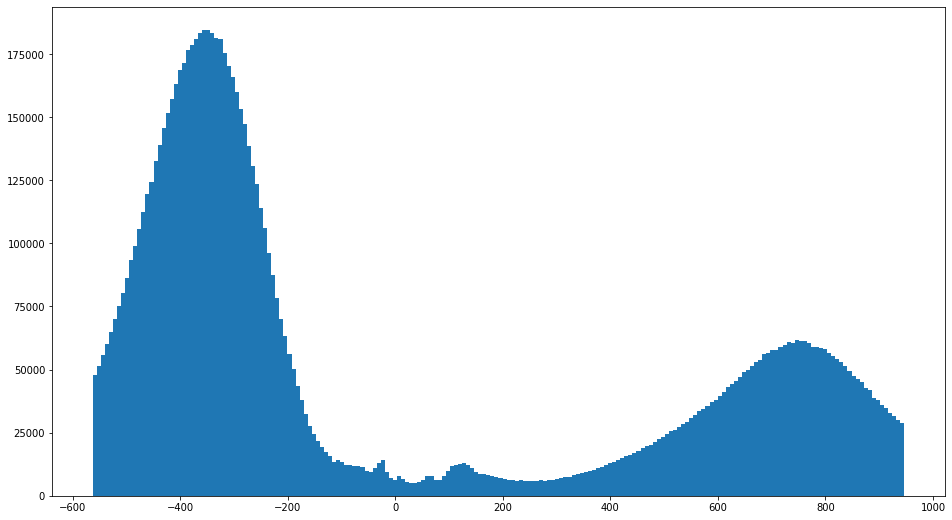

In [9]:
plt.figure(figsize=(16, 9))
perc1 = np.percentile(adj, 5)
perc2 = np.percentile(adj, 95)

mask = (adj.ravel() > perc1) & (adj.ravel() < perc2)

_ = plt.hist(adj.ravel()[mask], bins=200)